Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning openCypher - Create, Update, and Delete Queries

This notebook is the fourth in a series of notebooks that walk through how to write queries using openCypher.

This notebook will build upon the items convered in the notebook "01-Basic-Read-Queries", "02-Variable-Length-Paths", and "03-Ordering-Functions-Grouping".  If you have not loaded the data from those notebooks, please follow the steps in the [Getting Started](#Getting-Started) section below.  If you have loaded the data, then you can jump ahead to the [Setting up the visualizations](#Setting-up-the-visualizations) section.

## Getting Started

For these notebooks, we will be leveraging a dataset from the book [Graph Databases in Action](https://www.manning.com/books/graph-databases-in-action?a_aid=bechberger) from Manning Publications.  


**Note:** These notebooks do not cover data modeling or building a data loading pipeline.  If you would like a more detailed description about how this dataset is constructed and the design of the data model came from, then please read the book.

To get started, the first step is to load data into the cluster.  Assuming the cluster is empty, this can be accomplished by running the cell below which will load our Dining By Friends data.

### Loading Data

In [ ]:
%seed --model Property_Graph --dataset dining_by_friends --run

### Looking at our graph data

Now that we have loaded our data, let's take a moment to look at what our data model looks like:


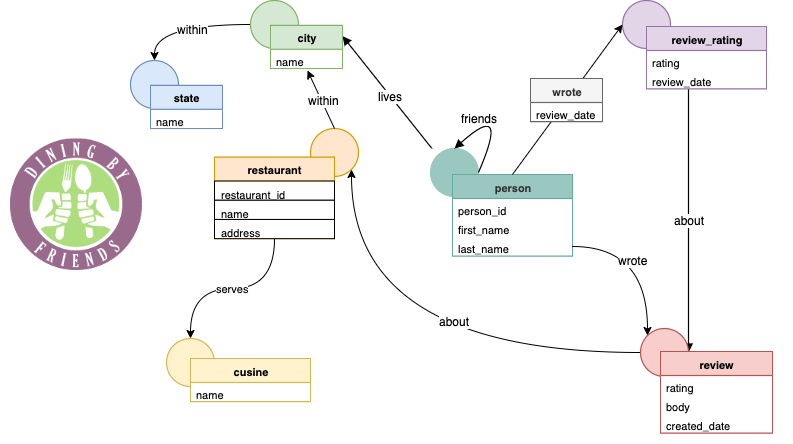

<table>
    <tr><th colspan=3 style="text-align: center">Element (Node/Edge) Counts</th>
    </tr>
<tr><td style="width:40%">
    
|Node Label|Count|
|:--|:--|
|review|109|
|restaurant|40|
|cuisine|24|
|person|8|
|state|2|
|city|2|
    
</td>
    <td></td>
    <td style="width:40%">

|Edge Label|Count|
|:--|:--|
|wrote|218|
|about|218|
|within|84|
|serves|80|
|friends|20|
|lives|16|

</td></tr> </table>

This dataset represents a fictitious, but realistic, restaurant recommendation application that contains:

* Users, represented by `person` nodes
* Users connected to Users via `friends` edges
* Restaurants and their associated information (`city`, `state`, `cusine`)
* Reviews include the body and ratings
* Ratings of reviews (helpful/not helpful)

This application contains three main aspects to the data it collects.  First, it contains a social network consisting of `person` nodes connected to other `person` nodes via a `friends` edge.  Second, it contains a restaurant review aspect consisting of `restaurant` nodes, information about those restaurants (`city`/`state`/`cuisine`), and `review` nodes for that restaurant.  The third, and final aspect, consists of a personalization component where a `person` can rate a `review`, which allows for better recommendations based on a person's preferences.

Throughout this set of notebooks, we will leverage the different aspects of this data to highlight different fundamental types of common property graph queries, namely neighborhood traversals, hierarchies, paths, and collaborative filtering.

Now let's get started.

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cusine":"name"}'


## Creating Data

When working with any database, one of the most common tasks is adding new data.  To add new nodes, edges, or path in openCypher we use the `CREATE` clause. 


### Creating a node with a label and properties
The simpliest option to create a node in openCypher is to do a query similar to this:

```
CREATE (n)
```
This query will create a node with a default label (`vertex`) and no properties.  If we wanted to return the newly created element, we could by adding a `RETURN` clause like shown here:

```
CREATE (n)
RETURN n
```

We can also create multiple elements simultaneously by specifying all of them in the `CREATE` clause, as seen here:

```
CREATE (n), (m)
RETURN n, m
```


While these examples help in understanding the basic syntax, they are not very realistic.  In most scenarios you will not want to just add a node, instead you will want to add a node with a specific label and associated properties.

Let's look at what our query looks like to create a new `person` node with the first name of `John` and a last name of `Doe`.

In [ ]:
%%oc -d $node_labels
CREATE (n:person {first_name: 'John', last_name: 'Doe'})
RETURN n

In the example above, the first and last name properties were added by specifying them inline with the node being created.  This can also be accomplished using the `SET` clause.  The `SET` clause allows you to specify a specific property to be added/updated (`SET n.first_name='Jane'`) or it can be assigned a map of key-value pairs which will all be added/updated, as shown in the example below.

In [ ]:
%%oc -d $node_labels
CREATE (n:person)
SET n={first_name: 'Jane', last_name: 'Doe'}
RETURN n

### Creating edges

Another common task is to create edges between nodes.  To create edges, we first use the `MATCH` statement to get the two nodes we would like to connect and then add the relationship between them using the `CREATE` clause.  

In the query below, we find the nodes we created above for `John Doe` and `Jane Doe` and connect them with a `friends` edge.

In [ ]:
%%oc -d $node_labels
MATCH (john:person {first_name: 'John', last_name:'Doe'}), (jane:person {first_name: 'Jane', last_name:'Doe'})  
CREATE (john)-[r:friends]->(jane)
RETURN r

As with nodes, we can also set properties on these edges using the `SET` clause as shown here:

In [ ]:
%%oc -d $node_labels
MATCH (john:person {first_name: 'John', last_name:'Doe'}), (jane:person {first_name: 'Jane', last_name:'Doe'})  
CREATE (john)-[r:friends]->(jane)
SET r.relationship='coworker'
RETURN r

### Creating paths
The last major task people want to do when adding data to their graph is to create entire paths containing both nodes and the connecting edges.  Using what we have already learned, we can accomplish this using a query like this:

```
CREATE (jim:person {first_name: 'Jim', last_name: 'Doe'})
CREATE (joe:person {first_name: 'Joe', last_name: 'Doe'})
CREATE (jim)-[:friends]->(joe)
```

While this is reasonable approach, we can increase the readability of this query a bit by adding them all within a single statement as shown below.

In [ ]:
%%oc -d $node_labels
CREATE p= (jim:person {first_name: 'Jim', last_name: 'Doe'})-[:friends]->
    (joe:person {first_name: 'Joe', last_name: 'Doe'})
RETURN p

## Updating Data

After creating data, the next most common task is to update data within the graph.  Lucky for us, we have already learned the building blocks we need to know to accomplish this task.  In openCypher, we combine the `MATCH` and `SET` clauses to update attributes on nodes and edges.  In the example below, let's update the `first_name` of the `Joe Doe` node we created in the previous step.

In [ ]:
%%oc -d $node_labels
MATCH (joe:person {first_name: 'Joe', last_name: 'Doe'})  
SET joe.first_name='Joseph'
RETURN joe

As we showed with the `CREATE` clause you can update the values by assigning a map of key-value pairs to an element.  When updating data you can also use a map with a `+=` to append or overwrite the key-value pairs from the map to that element.  In the example below, we are going to add a new property `age` to our `Joseph Doe` node.

In [ ]:
%%oc -d $node_labels
MATCH (joe:person {first_name: 'Joseph', last_name: 'Doe'})  
SET joe += {age: 43}
RETURN joe

Another feature when using `SET` is that you can remove a property by setting that property key to `null`, as shown in the example below.

In [ ]:
%%oc -d $node_labels
MATCH (joe:person {first_name: 'Joseph', last_name: 'Doe'})  
SET joe.age = null
RETURN joe

## Upserting Data

We have learned how to create and update data in our graph. However, there is another important mutation operation that we want to cover.  That operation is how to perform an upsert, where data is created if it doesn't exist or updated if it does.  In openCypher, this operation is performed using the `MERGE` clause.  `MERGE` can be thought of as a combination of `MATCH` and `CREATE` with the additional ability to specify what to do on a create or a match.  

**Note:** The `MERGE` clause does not support partial pattern matches.  When matching against patterns in `MERGE`, the matches are either the entire pattern, or the entire pattern is created.

The `MERGE` clause is divided into three sections:

* `MERGE` - This specifies the pattern(s) that you want to match in the graph
* `ON CREATE` - This specifies the behavior to occur if the pattern is created
* `ON MATCH` - This specifies the behavior to occur if the pattern is matched

Of these three portions, only the `MERGE` is required.  

### Upserting Nodes

Let's take a look at what a simple `MERGE` statement looks like with a single node pattern match.

In [ ]:
%%oc -d $node_labels
MERGE (p:person {first_name: "Jamie"})
RETURN p

In this case, we created a new node as there are no matches for the specified pattern.  However, let's say that if you created the node that you wanted to specify additional properties beyond the ones in the pattern match.  This is where we can leverage the `ON CREATE` portion of the `MERGE` clause as shown below.

In [ ]:
%%oc -d $node_labels
MERGE (p:person {first_name: "Jamie"})
ON CREATE
    SET p.creation = 'Now'
RETURN p

We can also specify the behavior for when the pattern is matched via the `ON MATCH` portion, as shown here:

In [ ]:
%%oc -d $node_labels
MERGE (p:person {first_name: "Jamie"})
ON CREATE
    SET p.creation = 'Now'
ON MATCH
    SET p.creation = 'Earlier'
RETURN p

### Upserting edges

The `MERGE` clause can also be used on to upsert edges.  Let's take the query we used above to create edges and update it to use `MERGE` instead.

In [ ]:
%%oc -d $node_labels
MATCH (john:person {first_name: 'John', last_name:'Doe'}), (jane:person {first_name: 'Jane', last_name:'Doe'})  
MERGE (john)-[r:friends]->(jane)
RETURN r

###  `UNWIND` with `MERGE`

So far, the options we have shown you work with a single item.  However, a common requirement is to send in a list of values and have them all added iteratively.  To accomplish this, we can leverage the `MERGE` clause as well as another new clause `UNWIND`.  `UNWIND` is a clause in openCypher that takes a list and expands it back to individual rows.  For example, if we ran the query below:

```
UNWIND [1,2,3] as x
RETURN x
```

We would get back the following results:

|x|
|--|
|1|
|2|
|3|

**Note:** One important thing to know is that while we are demonstrating the `UNWIND` clause in the context of creating/merging data, this is not the only way it can be used.  The `UNWIND` clause has multiple other uses when dealing with lists beyond what is shown here.

The ability to pass in a list of values and have them transformed into individual rows to optimize insertion of data.  In the example below, we use a `WITH` clause to inject an array of maps.  We then use the `UNWIND` clause to turn this into 3 individual rows, which are then used as inputs to the `MERGE` statement.

In [ ]:
%%oc -d $node_labels
 WITH [{first_name:"Dave"},{first_name:"Josh"},{first_name:"Steve"}] as names

UNWIND names as name
MERGE (n:person {first_name: name.first_name})
RETURN n

## Deleting Data

Now that we have learned about how to add and update data in our graph, the final operation we need to learn is how to delete data.  In openCypher, deletion of data is done with the `DELETE` clause for removing nodes or edges.

### Removing a Node

To remove a node(s) in openCypher, we first need to match the items we want to delete, via `MATCH`, and then remove them using `DELETE`.  In the example below, we will remove any nodes with the `first_name` of `Steve` from our graph.

In [ ]:
%%oc -d $node_labels
MATCH (n:person {first_name: 'Steve'})
DELETE n
RETURN n

### Removing an Edge
To remove an edge(s) in openCypher is very similar to removing a node, except that we need to pass the edge to `DELETE`. In the example below, we will remove any edges associated with nodes with the `first_name` of `Joseph` from our graph.

In [ ]:
%%oc
MATCH (n:person {first_name: 'Joseph'})-[r]-()
DELETE r
RETURN r

### Deleting Nodes and Edges

One common tripping point with `DELETE` queries is that if you are trying to delete a node that is attached to an edge.  If you do this, then the error will be returned:

```
"Cannot delete node, because it still has relationships. To delete this node, you must first delete its relationships."
```

To avoid this, we can delete all the relationships and then the node, like this:

```
MATCH (n:person {first_name: 'Joseph'})-[r]-()
DELETE r
DELETE n
```

The other option is to use the `DETACH DELETE` version of the clause which allows you to specify just the node and it will remove all adjacent edges and then the node.  The example below removes all edges and nodes with a name of `John Doe`. 

In [ ]:
%%oc -d $node_labels
MATCH (n:person {first_name: 'John', last_name: 'Doe'})
DETACH DELETE n
RETURN n

## Exercises

Now that we have gone through the concepts of openCypher mutation queries, it's time to put it into practice.  Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the openCypher queries specified below.

### Exercise M-1 Create a new person `Leonhard Euler`  and connect them to `Dave`?

Using the data model above, write a query that will:

* Create a new `person` node with a name of `Leonhard Euler` 
* Connect the new node to `Dave` via a `friends` edge
* Return the new connection

The results for this query are the new edge's id

In [ ]:
%%oc -d $node_labels


### Exercise M-2 Upsert the a list of followers and add an edge to `Dave`?

Using the data model above, write a query that will:

* Given the following list:
    ```
    [{first_name: 'Taylor', last_name: 'Hall'},{first_name: 'Kelvin', last_name: 'Fernsby'},{first_name: 'Ian', last_name: 'Rochester'}]
    ```
* Add or update `person` nodes for each item in the list
* Add or update a `follower` relationship between each new node and `Dave`
* If the edge is created write a property `creation` with a value `Created`
* If the edge already exists write a property `creation` with a value `Updated`
* Return the new edge elements
* This query should be re-runable without creating new nodes or edges

The results for this query are the three edge elements

In [ ]:
%%oc -d $node_labels


### Exercise M-3 Delete all `followers` edges and remove any connected nodes with no other edges?

Using the data model above, write a query that will:

* Find all the followers edges and connected nodes and remove the edges
* For each of the connected nodes see if they have any other edges
* If they have edges then ignore them
* If they have no edges then remove them
* Return the number of edges removed and the number of nodes removed

The results for this query are:

|node_cnt|edge_cnt|
|--|--|
|3|6|

In [ ]:
%%oc -d $node_labels


## Conclusion

In this notebook, we explored how to write queries to mutate data in openCypher.  This brings us to the end of our learning session on openCypher.  Throughout these notebooks, we have walked through the most common usage patterns for openCypher and applied those to common query patterns for property graph queries.  We hope that you now feel that you have a strong foundational understanding of how to approach and write openCypher queries.